# Machine Learning
### Agglomerative hierarchical clustering: single-linkage, complete-linkage, average-linkage, and Ward-linkage
We may unify agglomerative hierarchical clustering in a single algorithmic framework that performs bottom-up cluster merging, 
- The only variation across methods (e.g., single, complete, average, Ward linkage) lies in how the **distance** between two clusters is computed.   

The core procedure is identical for all variants:
- Start with each data point as its own cluster.
- Repeatedly merge the two closest clusters.
- Update cluster representations.
- Continue until one cluster remains (or a stopping criterion is met).
    
The **linkage** criterion—a function that defines inter-cluster **distance**—determines the clustering behavior:
- Single: min pairwise distance  
- Complete: max pairwise distance  
- Average: mean pairwise distance  
- Ward: increase in within-cluster sum of squares (WCSS)
         
<hr>

In the following, we implement a **unified** agglomerative hierarchical clusteirng (HC) in a single Python function. This unified HC gets the data points and the linkage method and the desired `k`. Then, it outputs the lists `merges` and `clusters`. <br> In the rest of this Notebook:
- We first test the **unified HC** for single-linkage clustering with two toy datasets to ensure this single-linkage works the same as the one implemented by the **Kruskal's algorithm** for minimum spanning tree (MST), expressed in the previous post.
- Then, we use the **iris dataset** for working with the clustering algorithm with all linkage methods.
- Finally, for comparsion we bring the code by **Scipy** for the four linkage clustering methods.

<hr>

**Reminder:** We said ealier that in the Iris dataset, there are three classes: Setosa, Versicolor, and Virginica.
- **Setosa** is well-separated from the other two classes.
- **Versicolor** and **Virginica** overlap significantly in the 4D feature space.     
     
<hr>

https://github.com/ostad-ai/Machine-Learning
<br> Explanation: https://www.pinterest.com/HamedShahHosseini/Machine-Learning/Data-Visualization

In [1]:
# Import required modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Define a unified HC
def unified_hc(points, k=None,linkage='single'):
    points = np.array(points)
    n = len(points)
    clusters = [[i] for i in range(n)]  # store indices
    
    # Precompute pairwise distances (for non-Ward)
    # Non-Ward: precompute distances
    if linkage != 'ward':
        dist_mat = np.linalg.norm(points[:, None] - points, axis=2)
        if linkage == 'single':
            link = lambda c1, c2: dist_mat[np.ix_(c1, c2)].min()
        elif linkage == 'complete':
            link = lambda c1, c2: dist_mat[np.ix_(c1, c2)].max()
        elif linkage == 'average':
            link = lambda c1, c2: dist_mat[np.ix_(c1, c2)].mean()
    
    # Ward: initialize state
    else:
        centroids = [points[i].copy() for i in range(n)]
        sizes = [1] * n    
    
    merges = []
    while len(clusters) > 1:
        min_dist = float('inf')
        best_pair=None
        if linkage != 'ward':
            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):
                    d = link(clusters[i], clusters[j])
                    if d < min_dist:
                        min_dist = d
                        best_pair = (i, j)
        else:
            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):
                    ni, nj = sizes[i], sizes[j]
                    ci, cj = centroids[i], centroids[j]
                    dist_sq = np.sum((ci - cj)**2)
                    wcss = (ni * nj / (ni + nj)) * dist_sq
                    d = np.sqrt(wcss)
                    if d < min_dist:
                        min_dist = d
                        best_pair =(i, j)       
        
        i, j = best_pair
        new_cluster = clusters[i] + clusters[j]
        merges.append((clusters[i], clusters[j], min_dist, len(new_cluster)))
        # Remove larger index first to avoid shifting
        del clusters[max(i, j)]
        del clusters[min(i, j)]
        clusters.append(new_cluster)
        
        # Compute new centroid and its size
        if linkage=='ward':
            new_size = sizes[i] + sizes[j]
            new_centroid = (sizes[i] * centroids[i] + sizes[j] * centroids[j]) / new_size
            # Update Ward state if needed
            # Remove old centroids and sizes
            del centroids[max(i, j)]
            del centroids[min(i, j)]
            del sizes[max(i, j)]
            del sizes[min(i, j)]
            centroids.append(new_centroid)
            sizes.append(new_size)
        
        if k is not None:
            if len(clusters)==k:
                break
    
    return merges,clusters

In [3]:
# Clustering with single-linkage
# Simple 2D example
points = np.array([
    [0, 0],
    [1, 1],
    [2, 2],
    [10, 10],
    [11, 11] ])

# Cluster points into two clusters
merges,clusters=unified_hc(points,k=2)

# Print points and their assigned clusters
print('--- Data points and assigned clusters ---')
for i,cluster in enumerate(clusters):
    for id in cluster:
        print(f'point={points[id]}, cluster={i}')

--- Data points and assigned clusters ---
point=[2 2], cluster=0
point=[0 0], cluster=0
point=[1 1], cluster=0
point=[10 10], cluster=1
point=[11 11], cluster=1


Cluster 0 with 10 samples
Cluster 1 with 10 samples
Cluster 2 with 10 samples


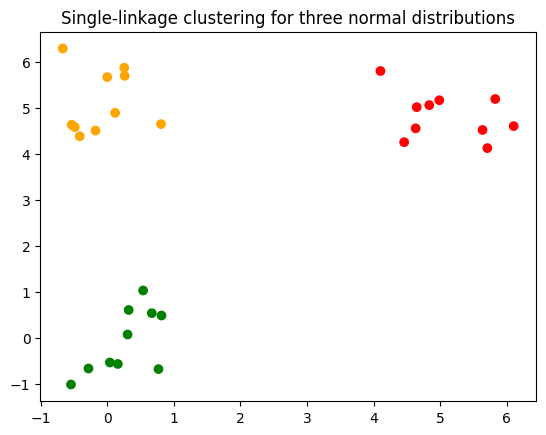

In [4]:
# Another clustering with single-linkage
# Example of three normal distributions 
# Three clear clusters
cluster1 = np.random.normal([0, 0], 0.5, (10, 2))
cluster2 = np.random.normal([5, 5], 0.5, (10, 2))  
cluster3 = np.random.normal([0, 5], 0.5, (10, 2))

points3 = np.vstack([cluster1, cluster2, cluster3])
n_points3 = len(points3)
#--------
colors3=np.array(['green','orange','red'])
_,clusters3 = unified_hc(points3, k=3)
labels3=np.zeros(len(points3),dtype='int')
for i, cluster in enumerate(clusters3):
    print(f'Cluster {i} with {len(cluster)} samples')
    for id in cluster:
        labels3[id]=i
plt.scatter(points3[:,0],points3[:,1],c=colors3[labels3])
plt.title('Single-linkage clustering for three normal distributions')
plt.show()

# Downloading Iris dataset to test our single-linkage clustering

In [5]:
# Download the iris dataset into a panda dataframe
df=pd.read_csv("https://raw.githubusercontent.com/ostad-ai/Machine-Learning/refs/heads/main/iris.csv")    

In [6]:
df.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Single-linkage, complete-linkage, average-linkage, and Ward-linkage
Here, we use the **iris** dataset and test it with four **agglomerative hierarchical** clusterings.
- **Single-linkage** clustering cannot recover three clusters in the Iris dataset due to the overlap between **versicolor** and **virginica**.
- **Complete-linkage**, **average-linkage**, and **Ward-linkage** clusterings perform better in face of overlapping clusters.

In [7]:
# Clsutering with the four linkage methods
# Example with iris data set
# Get the feature vectors in rows
xs=df.values[:,:4].astype('float')

# Ask the clusterings to cluster into three clusters
for link_type in ['single','complete','average','ward']:
    _,clusters_iris = unified_hc(xs, k=3,linkage=link_type)
    labels_iris=np.zeros(xs.shape[0],dtype='int')

    # Two clusters merge into one for single-linkage only
    print(f'Clustering of Iris into three clusters by {link_type}-linkage')
    print('No. of samples in each cluster:')
    for i,cluster in enumerate(clusters_iris):
        print(f'Cluster {i} with {len(cluster)} samples')
        for id in cluster:
            labels_iris[id]=i

Clustering of Iris into three clusters by single-linkage
No. of samples in each cluster:
Cluster 0 with 2 samples
Cluster 1 with 50 samples
Cluster 2 with 98 samples
Clustering of Iris into three clusters by complete-linkage
No. of samples in each cluster:
Cluster 0 with 28 samples
Cluster 1 with 50 samples
Cluster 2 with 72 samples
Clustering of Iris into three clusters by average-linkage
No. of samples in each cluster:
Cluster 0 with 50 samples
Cluster 1 with 36 samples
Cluster 2 with 64 samples
Clustering of Iris into three clusters by ward-linkage
No. of samples in each cluster:
Cluster 0 with 50 samples
Cluster 1 with 36 samples
Cluster 2 with 64 samples


# Linkage clustering of scipy

In [8]:
# For double-checking, uncomment the code below to see
# the results from Scipy hierarchical clustering
# for iris dataset
#---------------------------------
from sklearn.datasets import load_iris
from scipy.cluster.hierarchy import linkage, fcluster

iris = load_iris()
X = iris.data
for link_type in ['single','complete','average','ward']:
    Z = linkage(X, method=link_type)
    labels2 = fcluster(Z, t=3, criterion='maxclust')  # force 3 clusters
    print(f'{link_type}-linkage: {np.unique(labels2, return_counts=True)}')

single-linkage: (array([1, 2, 3], dtype=int32), array([50,  2, 98], dtype=int64))
complete-linkage: (array([1, 2, 3], dtype=int32), array([72, 28, 50], dtype=int64))
average-linkage: (array([1, 2, 3], dtype=int32), array([50, 36, 64], dtype=int64))
ward-linkage: (array([1, 2, 3], dtype=int32), array([50, 36, 64], dtype=int64))


<hr style="height:3px; background-color:lightgreen">

## Extra: Display the iris dataset with two of its features

In [9]:
# Add a new column to dataframe as ClassNumber 
# to give the classses in numbers {0,1,2}
classNames=df['Class'].unique()
df['ClassNumber']=-1
for i,className in enumerate(classNames):
    idxs=np.where(df.values[:,4]==className)
    df['ClassNumber'].values[idxs]=i
df.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Class,ClassNumber
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


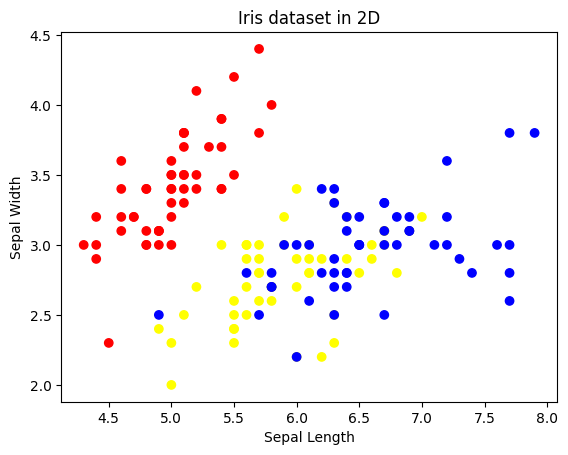

In [10]:
# Now, Display the iris dataset with two features
# Get data pairs (x,y)
xs=df.values[:,:4].astype('float')
ys=df.values[:,-1].astype('int')
colors=np.array(['red','yellow','blue'])
features=list(df.columns[:4])
f_indices=0,1
# Plot the data points and their class with colors
plt.scatter(xs[:,f_indices[0]],xs[:,f_indices[1]],c=colors[ys])
plt.title('Iris dataset in 2D')
plt.xlabel(features[f_indices[0]])
plt.ylabel(features[f_indices[1]])
plt.show()